In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

from itertools import combinations
from pathlib import Path

import arviz as az
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import mode
from sklearn.metrics import (
    adjusted_mutual_info_score,
    adjusted_rand_score,
)
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

from ppcluster import logger
from ppcluster.config import ConfigManager
from ppcluster.cvat import read_spatial_priors_from_cvat
from ppcluster.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_image,
    get_multi_dic_data,
)
from ppcluster.mcmc import (
    assign_spatial_priors,
    collect_run_metadata,
    compute_posterior_assignments,
    plot_spatial_priors,
    plot_velocity_clustering,
    plot_velocity_magnitude,
    sample_model,
    save_run_metadata,
)
from ppcluster.preprocessing import (
    apply_2d_gaussian_filter,
    apply_dic_filters,
    spatial_subsample,
)
from ppcluster.roi import PolygonROISelector
from ppcx_models import (
    build_marginalized_mixture_model,
)

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

In [16]:
SAVE_OUTPUTS = True  # Set to True to save inference results
LOAD_EXISTING = False  # Set to False to run sampling again

# MCMC parameters
DRAWS = 2000  # Number of MCMC draws
TUNE = 1000  # Number of tuning steps
CHAINS = 4  # Number of MCMC chains
CORES = 4  # Number of CPU cores to use
TARGET_ACCEPT = 0.9  # Target acceptance rate for NUTS sampler

# Data selection parameters
camera_name = "PPCX_Tele"
reference_start_date = "2024-08-02"
reference_end_date = "2024-08-02"
dt_min = 72  # Minimum time difference between images in hours
dt_max = 96  # Maximum time difference between images in hours
# dt_min = 24  # 72  # Minimum time difference between images in hours
# dt_max = 200  # 96  # Maximum time difference between images in hours

SUBSAMPLE_FACTOR = 1  # 1=Take every n point
SUBSAMPLE_METHOD = "random"  # or 'random', 'stratified'

# Parse various parameters from config file (or set manually here)
variables_names = ["V"]
roi_path = config.get("data.roi_path")
filter_kwargs = dict(
    filter_outliers=True,
    tails_percentile=0.01,
    min_velocity=1,
    apply_2d_median=False,
    median_window_size=5,
    median_threshold_factor=3,
    apply_2d_gaussian=False,
    gaussian_sigma=1.0,
)

# == PRIORS ==
# Define a specific prior probability for each sector (overrides PRIOR_STRENGTH)
# This is a dictionary where keys are sector names and values are lists of prior probabilities (Sector names must match those in the XML file)
# Sector name: [P(Cluster A), P(Cluster B), P(Cluster C)...]
# PRIOR_PROBABILITY = {
#     "A": [0.7, 0.25, 0.05, 0],
#     "B": [0.3, 0.4, 0.3, 0],
#     "C": [0.05, 0.35, 0.6, 0],
#     "D": [0.0, 0.5, 0.3, 0],
# }
SECTOR_PRIOR_FILE = Path("data/priors_3_sectors.xml")
PRIOR_PROBABILITY = {
    "A": [0.7, 0.3, 0.0],
    "B": [0.3, 0.4, 0.3],
    "C": [0.0, 0.4, 0.6],
}

# Output paths
output_dir = Path("output") / f"{camera_name}_{reference_end_date}_mcmc_multiscale"
output_dir.mkdir(parents=True, exist_ok=True)
base_name = f"{reference_start_date}_{reference_end_date}"


In [8]:
# Get DIC analysis metadata
dic_ids = get_dic_analysis_ids(
    db_engine,
    camera_name=camera_name,
    reference_date_start=reference_start_date,
    reference_date_end=reference_end_date,
    time_difference_min=dt_min,
    time_difference_max=dt_max,
)
if len(dic_ids) < 1:
    raise ValueError("No DIC analyses found for the given criteria")

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)
print(dic_analyses)

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(
    master_image_id,
    camera_name=camera_name,
    config=config,
)

# Fetch DIC data
out = get_multi_dic_data(
    dic_ids,
    stack_results=False,
    config=config,
)
logger.info(f"Found stack of {len(out)} DIC dataframes. Run filtering...")

# Apply filter for each df in the dictionary and then stack them
processed = []
for src_id, df_src in out.items():
    try:
        processed.append(apply_dic_filters(df_src, **filter_kwargs))
    except Exception as exc:
        logger.warning("Filtering failed for %s: %s", src_id, exc)
if not processed:
    raise RuntimeError("No dataframes left after filtering.")
df = pd.concat(processed, ignore_index=True)
logger.info("Data shape after filtering and stacking: %s", df.shape)

# Apply ROI filter
selector = PolygonROISelector.from_file(roi_path)
df = selector.filter_dataframe(df, x_col="x", y_col="y")

# Apply subsampling AFTER ROI filtering
if SUBSAMPLE_FACTOR > 1:
    df_subsampled = spatial_subsample(
        df, n_subsample=SUBSAMPLE_FACTOR, method=SUBSAMPLE_METHOD
    )
    df = df_subsampled
    logger.info(f"Data shape after subsampling: {df.shape}")

# Read spatial priors
sectors = read_spatial_priors_from_cvat(SECTOR_PRIOR_FILE, image_name=None)

2025-09-24 15:26:11 | [INFO    ] Found 1 DIC analyses matching criteria


   dic_id camera_name          master_timestamp           slave_timestamp  \
0    1915   PPCX_Tele 2024-07-30 05:00:18+00:00 2024-08-02 05:00:18+00:00   

   master_image_id  slave_image_id  dt_hours  
0            34633           34670        72  


2025-09-24 15:26:12 | [INFO    ] Fetched DIC data for id 1915 with 3927 points
2025-09-24 15:26:12 | [INFO    ] Found stack of 1 DIC dataframes. Run filtering...
2025-09-24 15:26:12 | [INFO    ] Starting DIC filtering pipeline with 3927 points
2025-09-24 15:26:12 | [INFO    ] Percentile filtering: 3927 -> 3850 points (removed 77 outliers)
2025-09-24 15:26:12 | [INFO    ] Min velocity filtering: 3850 -> 2856 points (removed 994 points below 1)
2025-09-24 15:26:12 | [INFO    ] DIC filtering pipeline completed: 3927 -> 2856 points (removed 1071 total)
2025-09-24 15:26:12 | [INFO    ] Data shape after filtering and stacking: (2856, 5)
2025-09-24 15:26:12 | [INFO    ] Filtered 2856 points to 2543 points inside polygon


## RUN MCMC multiple times with different smoothing scales and median the clustering results


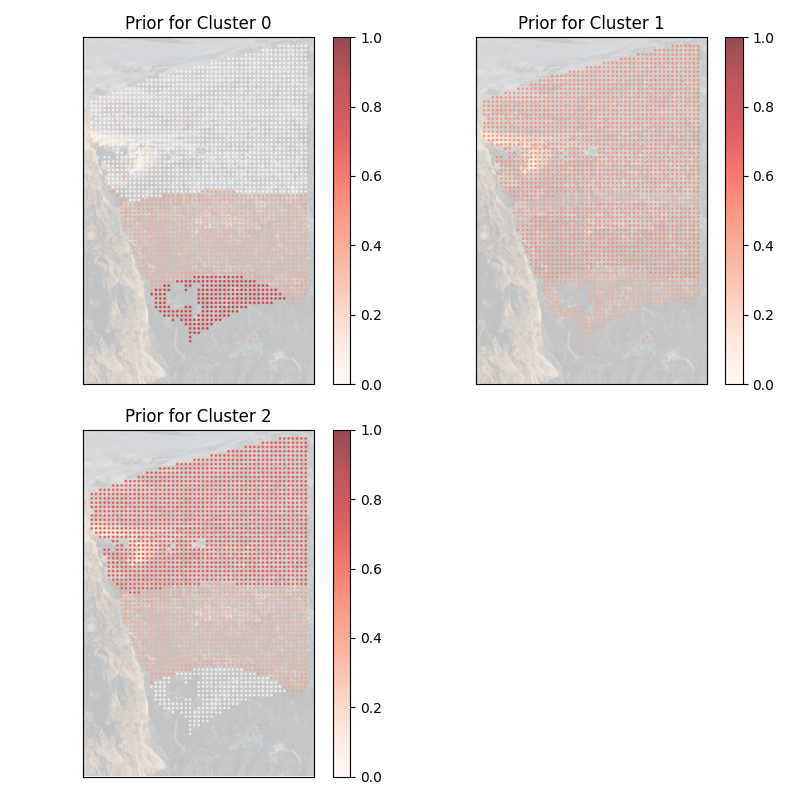

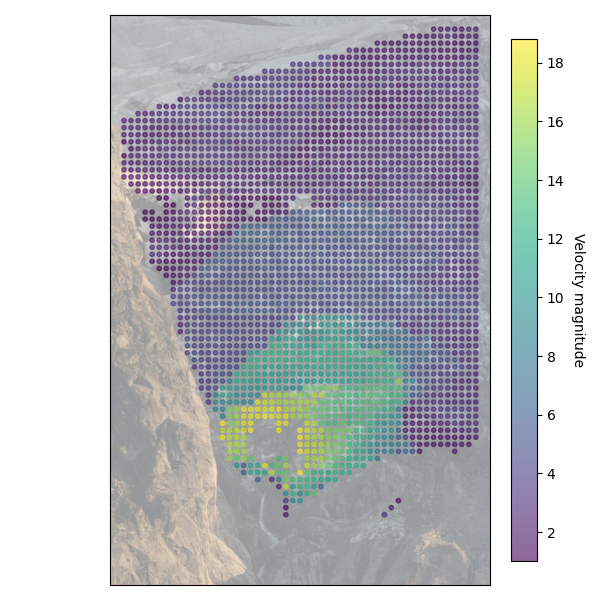

In [9]:
sigma_values = [2, 3]  # Different Gaussian smoothing scales

# Assign spatial priors
prior_probs = assign_spatial_priors(
    x=df["x"].to_numpy(),
    y=df["y"].to_numpy(),
    polygons=sectors,
    prior_probs=PRIOR_PROBABILITY,
    # method="exponential",
    # method_kws={"decay_rate": 0.001},
)

fig, axes = plot_spatial_priors(df, prior_probs, img=img)
fig.savefig(
    output_dir / f"{base_name}_spatial_priors.jpg",
    dpi=150,
    bbox_inches="tight",
)

# Plot velocity field
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_velocity_magnitude(
    df["x"].to_numpy(),
    df["y"].to_numpy(),
    df["V"].to_numpy(),
    img=img,
    ax=ax,
)
fig.savefig(
    output_dir / f"{base_name}_velocity_field.jpg",
    dpi=150,
    bbox_inches="tight",
)

In [10]:
# from ppcluster.preprocessing import create_2d_grid

# img_height = img.size[1]

# # Create 2D grid for velocity field
# X, Y, u_grid, v_grid, v_mag_grid, valid_mask = create_2d_grid(df)

# # Calculate velocity gradient (derivative)
# vel_gradient = np.gradient(v_mag_grid)

In [11]:
# # Identify significant velocity transitions (large negative gradients)
# transition_points = []
# for i in range(1, len(vel_gradient)):
#     # Detect significant negative gradient (velocity decrease)
#     if vel_gradient[i] < -0.2 * np.std(vel_gradient):
#         transition_points.append((bin_centers[i], mean_velocities[i]))


In [12]:
# # Plot velocity profile and transitions
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# # Plot mean velocity by height
# ax1.plot(mean_velocities, bin_centers, "b-", linewidth=2)
# ax1.set_xlabel("Mean Velocity")
# ax1.set_ylabel("Height (y coordinate)")
# ax1.set_title("Vertical Velocity Profile")

# # Mark transition points
# for point in transition_points:
#     ax1.axhline(y=point[0], color="r", linestyle="--", alpha=0.7)

# # Plot velocity gradient
# ax2.plot(vel_gradient, bin_centers[:-1], "g-", linewidth=2)
# ax2.set_xlabel("Velocity Gradient")
# ax2.set_ylabel("Height (y coordinate)")
# ax2.set_title("Vertical Velocity Gradient")

# # Draw the clusters with horizontal boundary lines
# if transition_points:
#     boundary_fig, boundary_ax = plt.subplots(1, 1, figsize=(8, 8))
#     if img is not None:
#         boundary_ax.imshow(img, alpha=0.5, cmap="gray")

#     # Plot clusters
#     for i, label in enumerate(np.unique(combined_cluster_pred)):
#         mask = combined_cluster_pred == label
#         boundary_ax.scatter(
#             df["x"][mask],
#             df["y"][mask],
#             color=plt.cm.tab10(i),
#             label=f"Cluster {label}",
#             s=10,
#             alpha=0.7,
#         )

#     # Draw horizontal lines at transition points
#     for point in transition_points:
#         boundary_ax.axhline(y=point[0], color="red", linestyle="--", linewidth=2)

#     boundary_ax.legend(loc="upper right")
#     boundary_ax.set_title("Velocity Transition Boundaries")
#     boundary_ax.set_xticks([])
#     boundary_ax.set_yticks([])


In [13]:
def run_mcmc_clustering(
    df_input,
    prior_probs,
    sectors,
    output_dir,
    base_name,
    img=None,
    feature_power=2,
    random_seed=8927,
    mu_params=None,
    sigma_params=None,
    sample_args=None,
):
    """
    Run MCMC-based clustering on velocity data.

    Parameters:
    -----------
    df_input : pandas.DataFrame
        Input dataframe with 'x', 'y', 'V' columns
    prior_probs : numpy.ndarray
        Prior probabilities for each point
    sectors : list
        List of sector polygons
    output_dir : Path
        Directory to save outputs
    base_name : str
        Base name for output files
    img : numpy.ndarray, optional
        Background image for plots
    feature_power : float, default=2
        Power to transform velocity values
    random_seed : int, default=8927
        Random seed for reproducibility
    mu_params : dict, optional
        Parameters for mu prior
    sigma_params : dict, optional
        Parameters for sigma prior
    sample_args : dict, optional
        Arguments for MCMC sampling

    Returns:
    --------
    dict
        Dictionary with all clustering results
    """
    logger.info(f"Running MCMC clustering for {base_name}...")

    # Make a copy to avoid modifying the input
    df_run = df_input.copy()

    # Apply power transform to emphasize high velocities (before scaling)
    df_run["V_transformed"] = df_run["V"] ** feature_power
    variables_names = ["V_transformed"]

    # Fit scaler on data
    scaler = StandardScaler()
    scaler.fit(df_run[variables_names].values)
    joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
    logger.info(
        f"Using features: {variables_names} with shape {df_run[variables_names].shape}"
    )

    # Scale data for model input
    data_array_scaled = scaler.transform(df_run[variables_names].to_numpy())

    # Default parameters if not provided
    if mu_params is None:
        mu_params = {"mu": 0, "sigma": 1}
    if sigma_params is None:
        sigma_params = {"sigma": 1}
    if sample_args is None:
        sample_args = dict(
            target_accept=0.95,
            draws=2000,
            tune=1000,
            chains=4,
            cores=4,
            random_seed=random_seed,
        )

    # Build model
    model = build_marginalized_mixture_model(
        data_array_scaled,
        prior_probs,
        sectors,
        mu_params=mu_params,
        sigma_params=sigma_params,
        feature_weights=[1.0, 0.3] if len(variables_names) > 1 else None,
    )

    # Sample model
    idata, convergence_flag = sample_model(model, output_dir, base_name, **sample_args)
    if not convergence_flag:
        idata_summary = az.summary(idata, var_names=["mu", "sigma"])
        logger.info(f"MCMC did not converge. Summary:\n{idata_summary}")

    # Compute cluster assignments
    posterior_probs, cluster_pred, uncertainty = compute_posterior_assignments(
        idata, n_posterior_samples=200
    )

    # Generate plots
    fig = plot_velocity_clustering(
        df_features=df_input,  # Use original data for plotting
        img=img,
        idata=idata,
        cluster_pred=cluster_pred,
        posterior_probs=posterior_probs,
        scaler=scaler,
    )
    fig.savefig(
        output_dir / f"{base_name}_results.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.close(fig)

    # Trace plots
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    az.plot_trace(
        idata, var_names=["mu", "sigma"], axes=axes, compact=True, legend=True
    )
    fig.savefig(output_dir / f"{base_name}_trace_plots.png", dpi=150)
    plt.close(fig)

    # Forest plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    az.plot_forest(idata, var_names=["mu", "sigma"], combined=True, ess=True, ax=axes)
    fig.savefig(output_dir / f"{base_name}_forest_plot.png", dpi=150)
    plt.close(fig)

    # Collect and save metadata
    metadata = collect_run_metadata(
        idata=idata,
        convergence_flag=convergence_flag,
        data_array_scaled=data_array_scaled,
        variables_names=variables_names,
        sectors=sectors,
        prior_probs=prior_probs,
        sample_args=sample_args,
        frame=locals(),
    )
    save_run_metadata(output_dir, base_name, metadata)

    # Return results dictionary
    result = {
        "metadata": metadata,
        "idata": idata,
        "scaler": scaler,
        "convergence_flag": convergence_flag,
        "posterior_probs": posterior_probs,
        "cluster_pred": cluster_pred,
        "uncertainty": uncertainty,
    }

    plt.close("all")
    return result

In [14]:
# Define sigma values for Gaussian smoothing
sigma_values = [2, 3]

# Loop through smoothing scales
results = []
for sigma in sigma_values:
    logger.info(f"Processing with Gaussian smoothing sigma={sigma}...")

    # Create scale-specific base name
    scale_base_name = f"{reference_start_date}_{reference_end_date}_sigma{sigma}"

    # Apply Gaussian smoothing if needed
    df_run = apply_2d_gaussian_filter(df, sigma=sigma) if sigma > 0 else df.copy()

    # Adjust model parameters based on scale
    mu_params = {"mu": 0, "sigma": 1 if sigma <= 2 else 0.5}
    sigma_params = {"sigma": 1 if sigma <= 2 else 0.5}

    # Run MCMC clustering with the smoothed data
    result = run_mcmc_clustering(
        df_input=df_run,
        prior_probs=prior_probs,
        sectors=sectors,
        output_dir=output_dir,
        base_name=scale_base_name,
        img=img,
        feature_power=2,  # Power transform parameter
        random_seed=RANDOM_SEED,
        mu_params=mu_params,
        sigma_params=sigma_params,
    )

    # Add scale information to result
    result["sigma"] = sigma

    # Append to results list
    results.append(result)

# Save all results to a single joblib file
# joblib.dump(
#     results,
#     output_dir
#     / f"{reference_start_date}_{reference_end_date}_all_results_multiscale.joblib",
# )

2025-09-24 15:26:25 | [INFO    ] Processing with Gaussian smoothing sigma=2...
2025-09-24 15:26:25 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=2
2025-09-24 15:26:25 | [INFO    ] Estimated grid spacing: 64.00
2025-09-24 15:26:25 | [INFO    ] Created 2D grid: (70, 51), 2543 valid points
2025-09-24 15:26:25 | [INFO    ] apply_2d_gaussian_filter: smoothed values assigned, NaN mapped points (total components)=0
2025-09-24 15:26:25 | [INFO    ] Running MCMC clustering for 2024-08-02_2024-08-02_sigma2...
2025-09-24 15:26:25 | [INFO    ] Using features: ['V_transformed'] with shape (2543, 1)
2025-09-24 15:26:25 | [INFO    ] Marginalized mixture model (un-sampled) created.
2025-09-24 15:26:25 | [INFO    ] Starting MCMC sampling...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
2025-09-24 15:27:07 | [INFO    ] Sampling completed.
2025-09-24 15:27:07 | [WARNING ] MCMC chains did not fully converge by r_hat/ess criteria.
2025-09-24 15:27:10 | [INFO    ] MCMC did not converge. Summary:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0, 0]     1.543  0.056   1.438    1.644      0.012    0.002      21.0   
mu[1, 0]    -0.406  0.083  -0.552   -0.351      0.041    0.024       7.0   
mu[2, 0]    -0.503  0.068  -0.546   -0.382      0.034    0.020       7.0   
sigma[0, 0]  1.121  0.036   1.050    1.18

Output()

/home/francesco/ppcx/ppcx-domains/.venv/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
2025-09-24 15:28:01 | [INFO    ] Sampling completed.
2025-09-24 15:28:01 | [WARNING ] MCMC chains did not fully converge by r_hat/ess criteria.
2025-09-24 15:28:04 | [INFO    ] MCMC did not converge. Summary:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0, 0]     1.036  0.754  -0.287    1.542      0.376    0.216       7.0   
mu[1, 0]     0.051  0.735  -0.386    1.370      0.366    0.212       7.0   
mu[2, 0]    -0.548  0.022  -0.563   -0.506      0.011    0.006       7.0   
sigma[0, 0]  0.857  0.424   0.108    1.14

In [15]:
# Read the results again
# results = joblib.load(
#     output_dir
#     / f"{reference_start_date}_{reference_end_date}_all_results_multiscale.joblib",
# )

2025-09-24 15:35:04 | [INFO    ] Overall stability score: 0.93
2025-09-24 15:35:04 | [INFO    ] Using 2/2 scales: sigma=[2 3]


['output/PPCX_Tele_2024-08-02_mcmc_multiscale/2024-08-02_2024-08-02_combined_clustering.joblib']

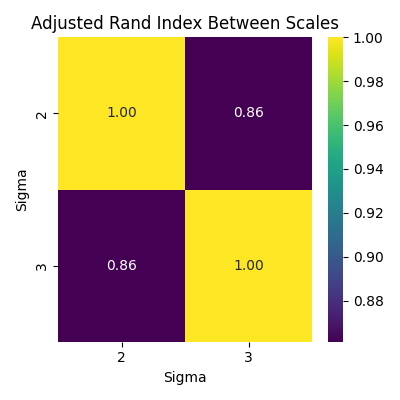

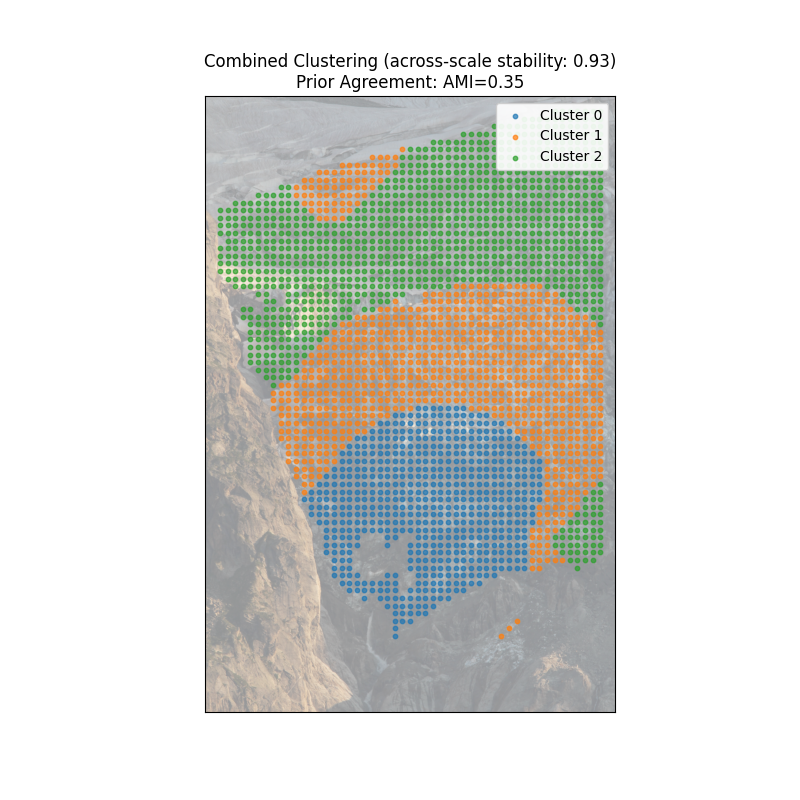

In [25]:
def aggregate_multiscale_clustering(
    results, similarity_threshold=0.6, overall_threshold=0.7, fig_path=None
):
    """
    Aggregate clustering results across scales, filtering unstable scales.

    Parameters:
    -----------
    results : list of dict
        Results from different scale clustering runs
    similarity_threshold : float
        Minimum mean similarity for a scale to be included
    overall_threshold : float
        Minimum overall similarity across scales to accept results

    Returns:
    --------
    combined_cluster_pred : ndarray
        Aggregated cluster assignments
    stability_score : float
        Measure of overall stability (0-1)
    """

    # Extract all cluster predictions
    all_cluster_preds = np.array([res["cluster_pred"] for res in results])
    n_scales = len(all_cluster_preds)
    sigma_values = [res["sigma"] for res in results]

    # Calculate pairwise similarities
    similarity_matrix = np.zeros((n_scales, n_scales))
    np.fill_diagonal(similarity_matrix, 1.0)
    for i, j in combinations(range(n_scales), 2):
        sim = adjusted_rand_score(all_cluster_preds[i], all_cluster_preds[j])
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim

    # Plot similarity heatmap
    if fig_path is not None:
        fig_path = Path(fig_path)
        fig_path.parent.mkdir(parents=True, exist_ok=True)
        fig, ax = plt.subplots(figsize=(4, 4))
        sns.heatmap(
            similarity_matrix,
            annot=True,
            fmt=".2f",
            cmap="viridis",
            xticklabels=sigma_values,
            yticklabels=sigma_values,
        )
        plt.title("Adjusted Rand Index Between Scales")
        plt.xlabel("Sigma")
        plt.ylabel("Sigma")
        plt.tight_layout()
        fig.savefig(fig_path, dpi=100, bbox_inches="tight")

    # Calculate mean similarity for each scale
    mean_similarities = np.mean(similarity_matrix, axis=1)

    # Filter scales with low similarity
    valid_scales = mean_similarities >= similarity_threshold
    if not np.any(valid_scales):
        raise ValueError(
            f"No scales meet the similarity threshold of {similarity_threshold}. "
            f"Mean similarities: {mean_similarities}"
        )

    # Get overall stability score (mean of valid scale similarities)
    valid_sim_matrix = similarity_matrix[np.ix_(valid_scales, valid_scales)]
    stability_score = valid_sim_matrix.mean()
    logger.info(f"Overall stability score: {stability_score:.2f}")

    # Check if overall stability is too low
    if stability_score < overall_threshold:
        raise ValueError(
            f"Overall clustering stability ({stability_score:.2f}) is below threshold "
            f"({overall_threshold}). Results are too unstable across scales."
        )

    # Get valid cluster predictions and compute mode
    valid_preds = all_cluster_preds[valid_scales]
    logger.info(
        f"Using {sum(valid_scales)}/{n_scales} scales: sigma={np.array(sigma_values)[valid_scales]}"
    )

    # Compute mode (most common label at each point)
    combined_cluster_pred, _ = mode(valid_preds, axis=0)
    combined_cluster_pred = combined_cluster_pred.flatten()

    return combined_cluster_pred, similarity_matrix, stability_score, valid_scales


combined_cluster_pred, similarity_matrix, stability_score, valid_scales = (
    aggregate_multiscale_clustering(
        results,
        similarity_threshold=0.7,
        overall_threshold=0.8,
        fig_path=output_dir
        / f"{reference_start_date}_{reference_end_date}_similarity_heatmap.jpg",
    )
)


# Create a "prior class" assignment based on the sector with highest probability
sector_names = list(PRIOR_PROBABILITY.keys())
sector_assignments = np.zeros_like(combined_cluster_pred)
for i, point_probs in enumerate(prior_probs):
    sector_assignments[i] = np.argmax(point_probs)

# Compute similarity metrics
ari = adjusted_rand_score(sector_assignments, combined_cluster_pred)
ami = adjusted_mutual_info_score(sector_assignments, combined_cluster_pred)

# Plot final combined clustering
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
if img is not None:
    ax.imshow(img, alpha=0.5, cmap="gray")

colormap = plt.get_cmap("tab10")
for i, label in enumerate(np.unique(combined_cluster_pred)):
    mask = combined_cluster_pred == label
    ax.scatter(
        df["x"][mask],
        df["y"][mask],
        color=colormap(i),
        label=f"Cluster {label}",
        s=10,
        alpha=0.7,
    )
ax.legend(loc="upper right", framealpha=0.9, fontsize=10)
ax.set_aspect("equal")
ax.set_title(
    f"Combined Clustering (across-scale stability: {stability_score:.2f})\n"
    f"Prior Agreement: AMI={ami:.2f}"
)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(
    output_dir / f"{reference_start_date}_{reference_end_date}_combined_clustering.png",
    dpi=300,
    bbox_inches="tight",
)

output = {
    "combined_cluster_pred": combined_cluster_pred,
    "stability_score": stability_score,
    "valid_scales": valid_scales,
    "sigma_values": sigma_values,
}
joblib.dump(
    output,
    output_dir
    / f"{reference_start_date}_{reference_end_date}_combined_clustering.joblib",
)

## RUN MCMC with stacked multiscale model


In [ ]:
# # Smooth the velocity field with a Gaussian filter with different scales and stack the features together in a single dataframe to run a multiscale analysis
# sigma_values = [1, 2, 3]  # Different Gaussian smoothing scales
# df_run = df.copy()
# for sigma in sigma_values:
#     smoothed = apply_2d_gaussian_filter(df, sigma=sigma)
#     df_run = pd.concat([df_run, smoothed])

# # Assign spatial priors
# prior_probs = assign_spatial_priors(
#     x=df_run["x"].to_numpy(),
#     y=df_run["y"].to_numpy(),
#     polygons=sectors,
#     prior_probs=PRIOR_PROBABILITY,
#     method="exponential",
#     method_kws={"decay_rate": 0.001},
# )

# fig, axes = plot_spatial_priors(df_run, prior_probs, img=img)
# fig.savefig(
#     output_dir / f"{base_name}_velocity_field.jpg",
#     dpi=150,
#     bbox_inches="tight",
# )

In [ ]:
# # df_run["log_y"] = np.log(df_run["y"] + 1e-6)

# # Fit scaler on data
# variables_names = ["V"]
# scaler = StandardScaler()
# scaler.fit(df_run[variables_names].values)
# joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
# logger.info(
#     f"Using features: {variables_names} with shape {df_run[variables_names].shape}"
# )

# # Scale data for model input
# data_array_scaled = scaler.transform(df_run[variables_names].to_numpy())

In [ ]:
# model = build_marginalized_mixture_model(
#     data_array_scaled,
#     prior_probs,
#     sectors,
#     mu_params={"mu": 0, "sigma": 1},
#     sigma_params={"sigma": 2},
#     feature_weights=[1.0, 0.3] if len(variables_names) > 1 else None,
# )

# # Sample model
# sample_args = dict(
#     target_accept=0.9,
#     draws=2000,
#     tune=1000,
#     chains=CHAINS,
#     cores=CORES,
#     random_seed=RANDOM_SEED,
# )
# idata, convergence_flag = sample_model(model, output_dir, base_name, **sample_args)

# idata_summary = az.summary(idata, var_names=["mu", "sigma"])
# print(idata_summary)

# metadata = collect_run_metadata(
#     idata=idata,
#     convergence_flag=convergence_flag,
#     data_array_scaled=data_array_scaled,
#     variables_names=variables_names,
#     sectors=sectors,
#     prior_probs=prior_probs,
#     sample_args=sample_args,
#     frame=locals(),  # Pass current local variables
# )

# save_run_metadata(output_dir, base_name, metadata)

# # Postprocess results
# posterior_probs, cluster_pred, uncertainty = postprocess_mcmc_results(
#     idata,
#     df_run,
#     scaler,
#     img,
#     output_dir,
#     base_name,
# )